In [92]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import math
def energy(distance,t):
    """
    Total energy of some path
    """
    return np.exp(-distance/t)
    
    
def distance(city1,city2):
    """
    Pairwise distance between two cities
    """
    R = 6373.0

    lat1 = radians(city1.Широта)
    lon1 = radians(city1.Долгота)
    lat2 = radians(city2.Широта)
    lon2 = radians(city2.Долгота)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def calculate_distance(cities):
    """
    Calculate total tour distance
    """
    pairs = zip(list(cities.itertuples())[0:-1],list(cities.itertuples())[1:])
    total = sum(map(lambda x: distance(x[0],x[1]),pairs))
    total += distance(cities.iloc[0],cities.iloc[-1]) # "return" distance
    return total

def full_shuffle(current):
    """
    Generate new sample by fully reshuffling path
    """
    new_state = current.sample(30)
    return new_state
    
def pairwise_swap(df):
    """
    Generate new sample by swapping two random cities
    """
    current = df.copy()
    high = len(current)
    first = np.random.randint(0,high)
    second = np.random.randint(0,high)
    a,b = current.iloc[first].copy(),current.iloc[second].copy()
    current.iloc[first],current.iloc[second] = b,a
    return current

def triple_swap(df):
    """
    Swap three random city
    """
    current = df.copy()
    high = len(current)
    first = np.random.randint(0,high)
    second = np.random.randint(0,high)
    third = np.random.randint(0,high)
    a,b,c = current.iloc[first].copy(),current.iloc[second].copy(),current.iloc[third].copy()
    current.iloc[first],current.iloc[second],current.iloc[third] = b,c,a
    return current
    
def simulated_annealing(state,T=3000,alpha=0.1,next_state=pairwise_swap):
    distance = calculate_distance(state)
    states = [state]
    temps = [T]
    distances = [calculate_distance(state)]
    while (T>1):
        new_state = next_state(state)
        new_distance = calculate_distance(new_state)
        acc_rate = energy(new_distance-distance,T)
        if np.random.random() <= acc_rate:
            state = new_state
            distance = new_distance
        states.append(state.copy())
        T = T*(1-alpha)
        temps.append(T)
        distances.append(distance)
    return states,temps,distances


def plot_map(cities):
    """
    Plot path on map 
    """
    import json 
    with open("russia.json") as json_file:
        json_data = json.load(json_file)
    poly = json_data[0]["geojson"]
    fig,ax = plt.subplots()
    al = json_data[0]['geojson']['coordinates']
    for coords in al:  
        x = [i for i,j in coords[0] if i>0]
        y = [j for i,j in coords[0] if i>0]
        ax = fig.gca() 
        ax.plot(x,y)
    pairs = zip(list(cities.iterrows())[0:-1],list(cities.iterrows())[1:])
    for a,b in pairs:
        city1 = a[1]
        city2 = b[1]
        y = [city1["Широта"],city2["Широта"]]
        x = [city1["Долгота"],city2["Долгота"]]
        ax.plot(x,y)
    city1,city2 = cities.iloc[0],cities.iloc[-1]
    y = [city1["Широта"],city2["Широта"]]
    x = [city1["Долгота"],city2["Долгота"]]
    ax.plot(x,y)
    
def plot_temperature(temperatures,title=""):
    """
    Plot temperature (huh)
    """
    plt.plot(temperatures)
    plt.xlabel("Iteration")
    plt.ylabel("Temperature")
    plt.title(title)
    plt.show()
    

def plot_distance(distances,title=""):
    """
    Plot distance output of algorithm
    """
    plt.plot(distances)
    plt.xlabel("Iteration")
    plt.ylabel("Total distance")
    plt.title(title)
    plt.show()

In [3]:
data = pd.DataFrame.from_csv("cities.csv")
#Drop Innopolis, it breaks next step :D 
data = data[data['Город']!="Иннополис"]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [4]:
data['Население'] = pd.to_numeric(data["Население"])

In [5]:
data = data[["Население","Широта","Долгота",'Город']]

In [37]:
target = data.sort_values("Население",ascending=False).iloc[:30] 

In [7]:
target

,Население,Широта,Долгота,Город
Индекс,,,,
101000.0,11514330,55.753879,37.620373,NaN
190000.0,4848742,59.939125,30.315822,NaN
630000.0,1498921,55.028102,82.921057,Новосибирск
620000.0,1377738,56.838633,60.605489,Екатеринбург
603000.0,1250615,56.324209,44.005395,Нижний Новгород
420000.0,1216965,55.794388,49.111531,Казань
443000.0,1164900,53.195166,50.106769,Самара
644000.0,1154000,54.984814,73.367464,Омск
454000.0,1130273,55.160366,61.400786,Челябинск


In [8]:
#Get some initial guess by shuffling our cities
initial_guess = target.sample(30,random_state=42)

0.1


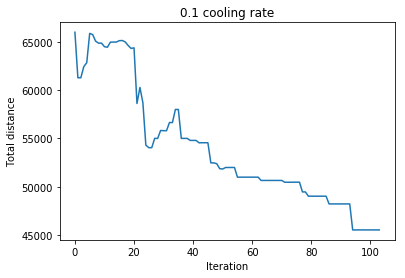

0.01


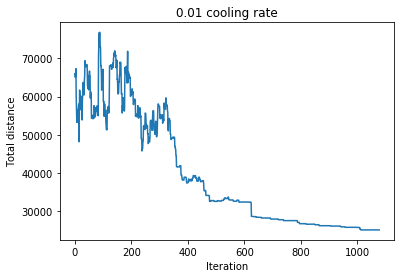

0.001


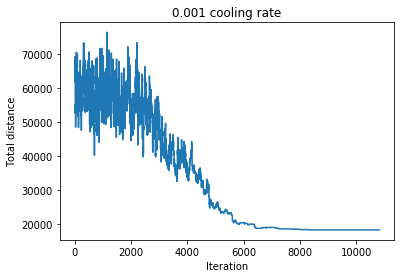

In [123]:
cooling_rates = [0.1,0.01,0.001]
triplets = []
np.random.seed(24)
for r in cooling_rates:
    print(r)
    s,t,d = simulated_annealing(initial_guess,T=50000,alpha=r)
    plot_distance(d,title=str(r)+" cooling rate")

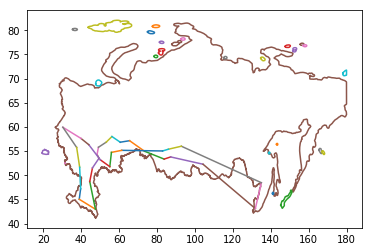

In [93]:
plot_map(s[-1]) ##I haven't managed to master projections. 

In [115]:
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate(states):
    """
    Animates simulation process, given state list. 
    """
    import json 
    with open("russia.json") as json_file:
        json_data = json.load(json_file)
    poly = json_data[0]["geojson"]
    print("a")
    fig, ax = plt.subplots()
    ax.set_xlim(20,140)
    ax.set_ylim(40,65)
    
    #Plot Russia
    al = json_data[0]['geojson']['coordinates']
    for coords in al:  
        x = [i for i,j in coords[0] if i>0]
        y = [j for i,j in coords[0] if i>0]
        ax = fig.gca() 
        ax.plot(x,y)
    
    #plot initial_guess (just to create enough lines)
    lines = []
    pairs = zip(list(initial_guess.iterrows())[0:-1],list(initial_guess.iterrows())[1:])
    for c1,c2 in pairs:
        city1 = c1[1]
        city2 = c2[1]
        y = [city1["Широта"],city2["Широта"]]
        x = [city1["Долгота"],city2["Долгота"]]
        lines.append(ax.plot(x,y))
    city1,city2 = initial_guess.iloc[0],initial_guess.iloc[-1]
    y = [city1["Широта"],city2["Широта"]]
    x = [city1["Долгота"],city2["Долгота"]]
    lines.append(ax.plot(x,y))
    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    def update(a,states,lines):
        """
        Update lines given step number, states and current lines
        """
        cities = states[a]
        ax.set_title("Iteration number: "+str(a))
        pairs = zip(list(cities.iterrows())[0:-1],list(cities.iterrows())[1:])
        for x,(a,b) in zip(lines,pairs):
            line = x[0]
            city1 = a[1]
            city2 = b[1]
            y = [city1["Широта"],city2["Широта"]]
            x = [city1["Долгота"],city2["Долгота"]]
            line.set_data(x,y)
        city1,city2 = cities.iloc[0],cities.iloc[-1]
        y = [city1["Широта"],city2["Широта"]]
        x = [city1["Долгота"],city2["Долгота"]]
        lines[-1][0].set_data(x,y)
        
        return lines 

    ani = FuncAnimation(fig, update,frames=range(0,len(states)-1), fargs=(states, lines))
    return ani

**Warning**  

Next code is really slow to run and requires additional libraries. Please refer to .mp4 files attached for vizualization

a


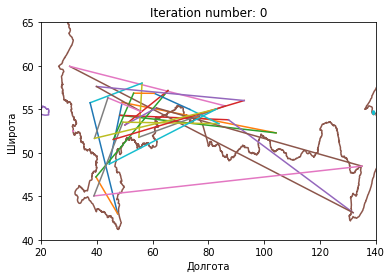

In [122]:
#Requires ffmpeg library in path
ani = animate(s)
ani.save('im1.mp4')